In [1]:
import numpy as np
from tqdm.autonotebook import tqdm, trange
import pandas as pd
import sys
sys.path.append('../utilities')

import evaluation
import load_data
import utils
import models_torch

C:\Users\Lyle\AppData\Local\Temp\ipykernel_74824\3717577850.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


Here are some settings to make sure the notebook runs:

In [2]:
#def_model_params is a list of: [batch_size, G_LR, D_LR, A_LR, noise_dim, epochs, n_hidden, layer_size]
def_model_params = [256, 3e-4, 3e-4, 3e-4, 8, 10, 1, 400] 
numinst = 1 #Number of instantiations to test
numgen = 5000 #Number of samples to generate
numanim = 1 #Number of intermediate steps to animate/score
scaling = True #Scale or not
scorebars = True #Print progress bars for scoring functions

Here are the settings from our actual experiments:

In [3]:
# def_model_params = [256, 3e-4, 3e-4, 3e-4, 8, 10000, 1, 400] 
# numinst = 4 #Number of instantiations to test
# numgen = 5000 #Number of samples to generate
# numanim = 1 #Number of intermediate steps to animate/score
# scaling = True #Scale or not
# scorebars = True #Print progress bars for scoring functions

100%|██████████| 625/625 [00:03<00:00, 156.94it/s, L_D_real=1.0886, L_D_neg=1.0683, L_D_fake=1.0661, L_G=1.1216]


Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.57s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.41s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:06<00:00,  1.35s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:06<00:00,  1.33s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:06<00:00,  1.35s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:06<00:00,  1.35s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.52s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.54s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:07<00:00,  1.55s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:08<00:00,  1.63s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:08<00:00,  1.67s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:08<00:00,  1.65s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:19<00:00,  3.87s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:19<00:00,  3.96s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:19<00:00,  3.82s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:21<00:00,  4.39s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:21<00:00,  4.40s/it]


Calculating DPP Diversity
Calculating F1


Calculating Precision/Recall:: 100%|==========| 5/5 [00:26<00:00,  5.20s/it]


Calculating DPP Diversity


<Figure size 640x480 with 0 Axes>

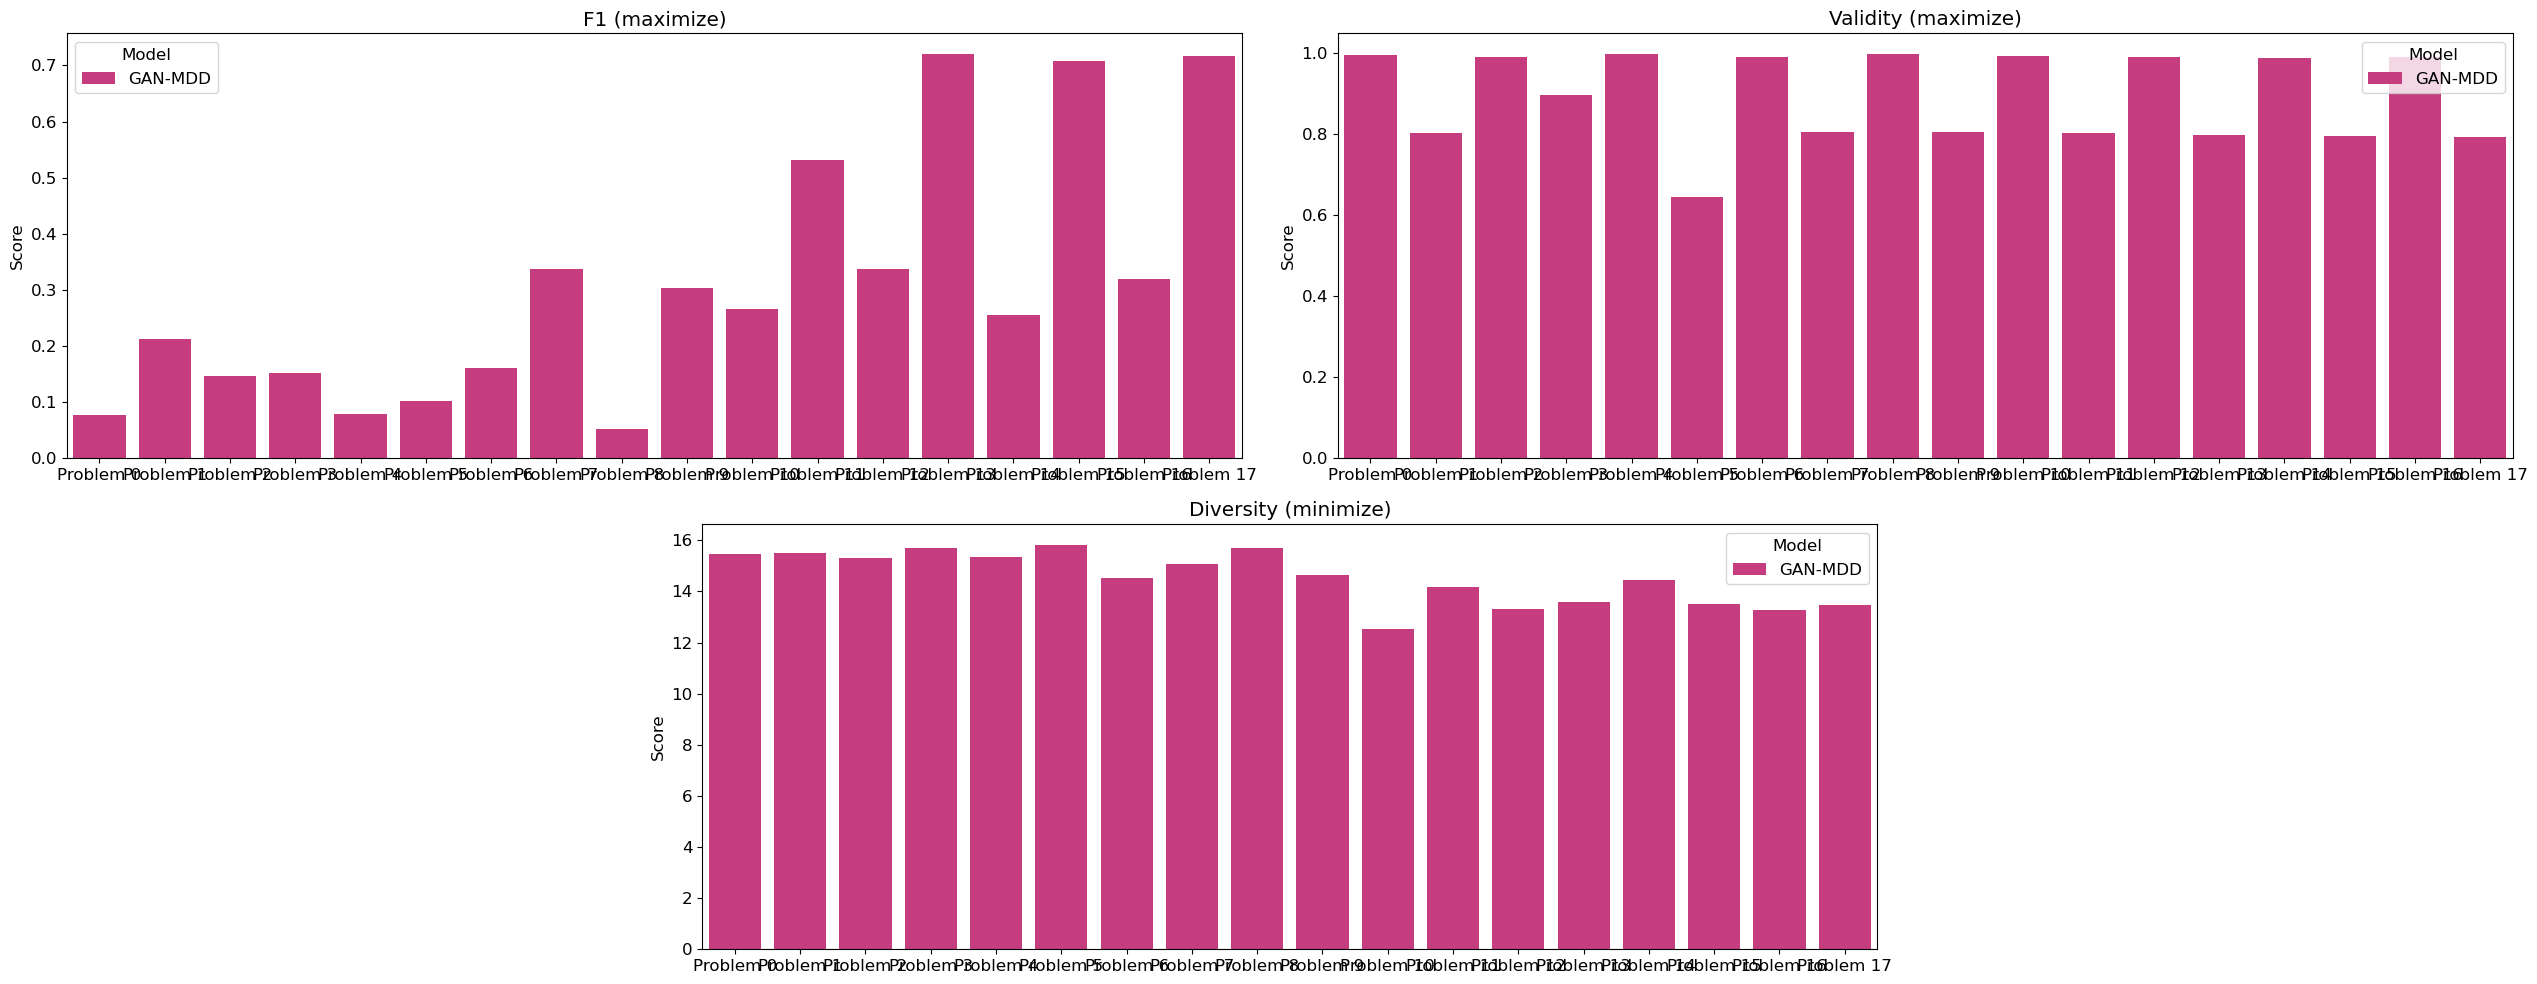

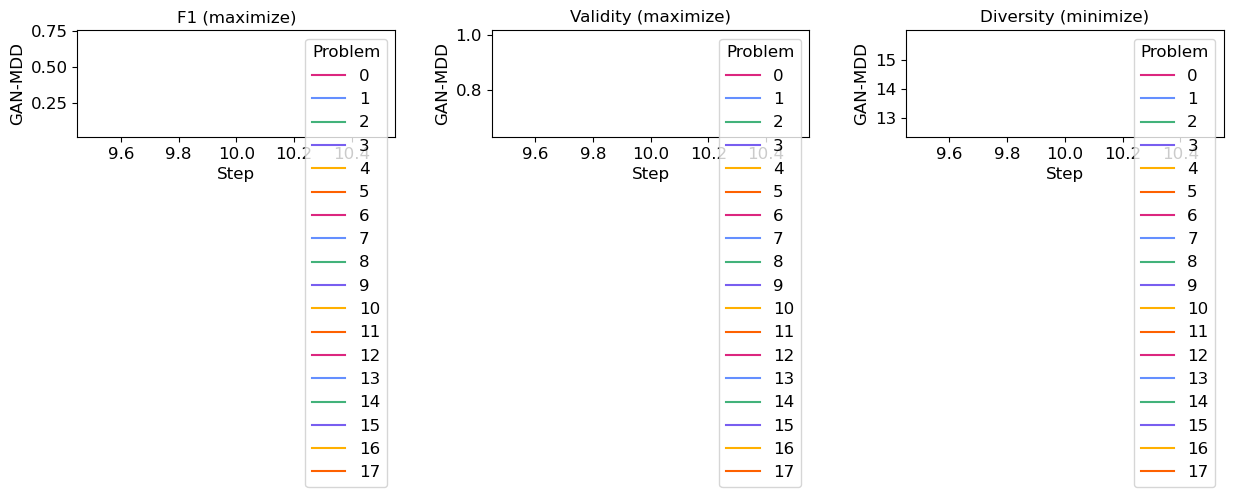

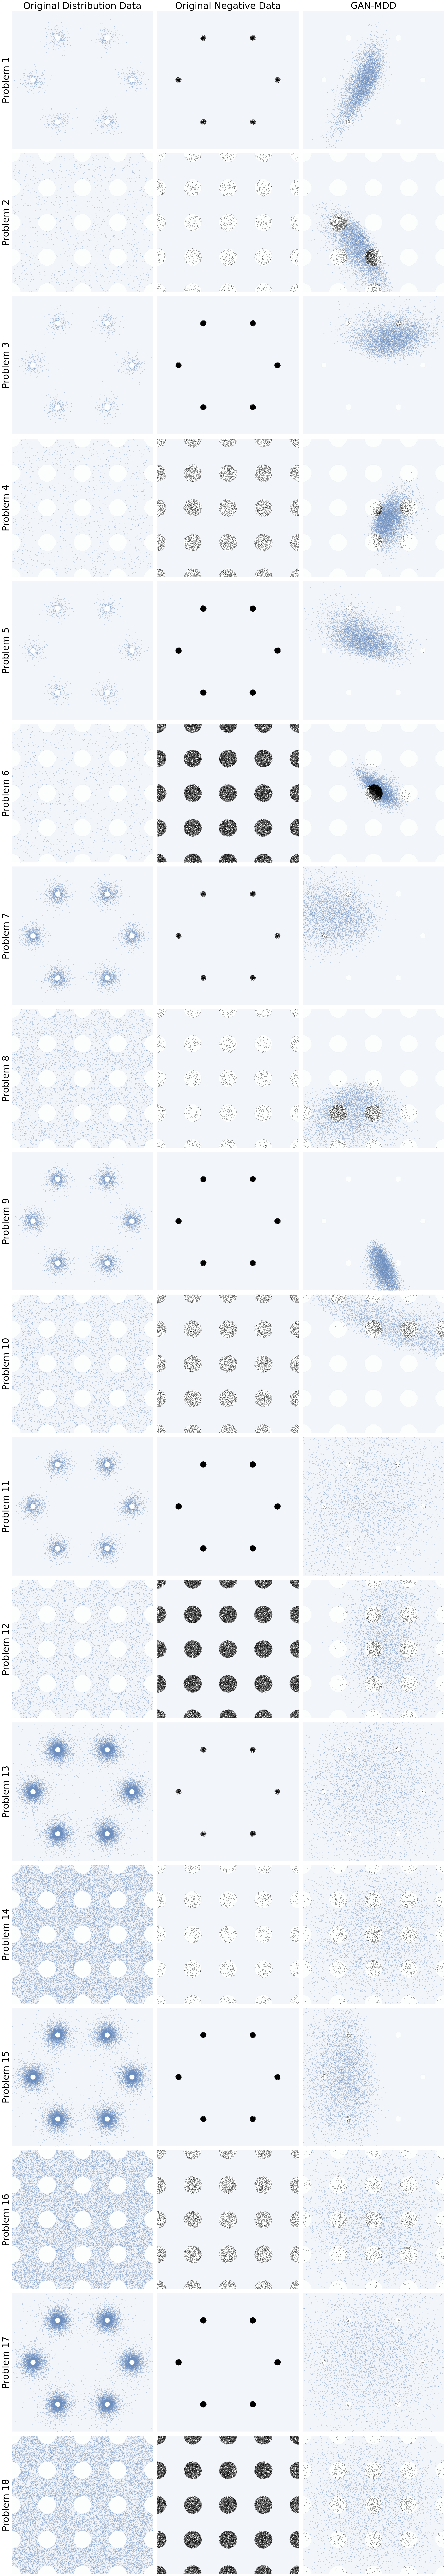

In [4]:
%matplotlib inline
np.random.seed(0) #ensures datasets are the same (models still random)

rangearr = np.array([[-1,1], [-1,1]])

functions=[]

def get_dataset_func(samplingfunction, validityfunction, rangearr):
    def sample(samplingfunction = samplingfunction, validityfunction=validityfunction, rangearr=rangearr):
        distribution, negative = samplingfunction(validityfunction, rangearr)
        positive = distribution #Positive will be ignored for now
        return distribution, negative, positive
    return sample

for num_pos in [1000, 4000, 16000]:
    for num_neg in [1000, 4000, 16000]:
        sampling_func_donuts = load_data.sample_circle_blobs_wrapper(num_pos, num_neg, 6, 0.7, 0.1)
        validity_func_donuts = load_data.inv_radial_circles_val_wrapper(0.7, 0.04, 6)
        datasetfunction_donuts = get_dataset_func(sampling_func_donuts, validity_func_donuts, rangearr)
        functions.append([datasetfunction_donuts, validity_func_donuts, None, rangearr, None, None])

        sampling_func_circgrid = load_data.sample_uniform_wrapper(num_pos, num_neg)
        validity_func_circgrid = load_data.circles_val_wrapper(0.25, 2)
        datasetfunction_circgrid = get_dataset_func(sampling_func_circgrid, validity_func_circgrid, rangearr)
        functions.append([datasetfunction_circgrid, validity_func_circgrid, None, rangearr, None, None])

#----------------------------------------------------------------------------------

#Select methods to test
methods=pd.Series()

#[train_step, validity_weight, diversity_weight]
methods["GAN-MDD"] = models_torch.train_wrapper(def_model_params, ["GAN_MDD", None, 0.0])

metrics=pd.Series()
metrics["F1"] = ["maximize", evaluation.F_wrapper("x", 1)]
metrics["Validity"] = ["maximize", "Validity"] #Validity is handled specially in utils
metrics["Diversity"] = ["minimize", evaluation.DPP_diversity_wrapper("x", 1000, 10, False)]


timestr = utils.fit_and_generate(functions, methods, numinst, numanim, numgen, scaling, 0, 0, holdout=0)
utils.score(timestr, functions, methods, metrics, numinst, scaling, 0, scorebars, plotscores=True, score_instances=True)
utils.plot_all(timestr, functions, methods, numinst, scaling, 1, 0, 0, 0, "blue", plot_steps=False)